In [48]:
# Import package yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# Set memory growth for GPU (jika menggunakan GPU)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU tersedia: {len(gpus)}")
    else:
        print("Tidak ada GPU yang terdeteksi, menggunakan CPU")
except Exception as e:
    print(f"Error dalam setup GPU: {e}")

Tidak ada GPU yang terdeteksi, menggunakan CPU


In [27]:

# Ganti 'nama_file_anda.csv' dengan nama file CSV Anda
df = pd.read_csv('/content/gojek_reviews.csv')

In [28]:
# Tampilkan info tentang dataset
print("\nInformasi Dataset:")
print(df.info())
print("\nContoh data:")
print(df.head())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257731 entries, 0 to 257730
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewId              257731 non-null  object 
 1   userName              257731 non-null  object 
 2   userImage             257731 non-null  object 
 3   content               257728 non-null  object 
 4   score                 257730 non-null  float64
 5   thumbsUpCount         257730 non-null  float64
 6   reviewCreatedVersion  203762 non-null  object 
 7   at                    257730 non-null  object 
 8   replyContent          75851 non-null   object 
 9   repliedAt             75851 non-null   object 
 10  appVersion            203762 non-null  object 
dtypes: float64(2), object(9)
memory usage: 21.6+ MB
None

Contoh data:
                               reviewId         userName  \
0  5a957f59-d97b-4ebb-81ba-76cbc950f80a  Pengguna Google   
1

In [17]:
# Cek distribusi skor
print("\nDistribusi skor:")
print(df['score'].value_counts().sort_index())


Distribusi skor:
score
1.0     6420
2.0      962
3.0      881
4.0     1262
5.0    15053
Name: count, dtype: int64


In [29]:
# Fungsi untuk praproses teks
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Hapus URL
        text = re.sub(r'http\S+', '', text)
        # Hapus mention dan hashtag
        text = re.sub(r'@\w+|#\w+', '', text)
        # Hapus karakter khusus dan angka
        text = re.sub(r'[^\w\s]|[\d]', '', text)
        # Hapus whitespace berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

In [30]:
# Membuat label sentimen berdasarkan skor
def create_sentiment_label(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:  # score >= 4
        return 'positif'

# Praproses teks
print("\nMemulai praproses teks...")
# Gunakan chunk processing untuk dataset besar
chunk_size = 50000
for i in range(0, len(df), chunk_size):
    end = min(i + chunk_size, len(df))
    print(f"  Memproses {i} sampai {end}...")
    df.loc[i:end-1, 'processed_content'] = df.loc[i:end-1, 'content'].apply(preprocess_text)



Memulai praproses teks...
  Memproses 0 sampai 50000...
  Memproses 50000 sampai 100000...
  Memproses 100000 sampai 150000...
  Memproses 150000 sampai 200000...
  Memproses 200000 sampai 250000...
  Memproses 250000 sampai 257731...


In [31]:
# Membuat label sentimen
df['sentiment'] = df['score'].apply(create_sentiment_label)

# Konversi label sentimen ke kode
sentiment_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df['sentiment_code'] = df['sentiment'].map(sentiment_map)

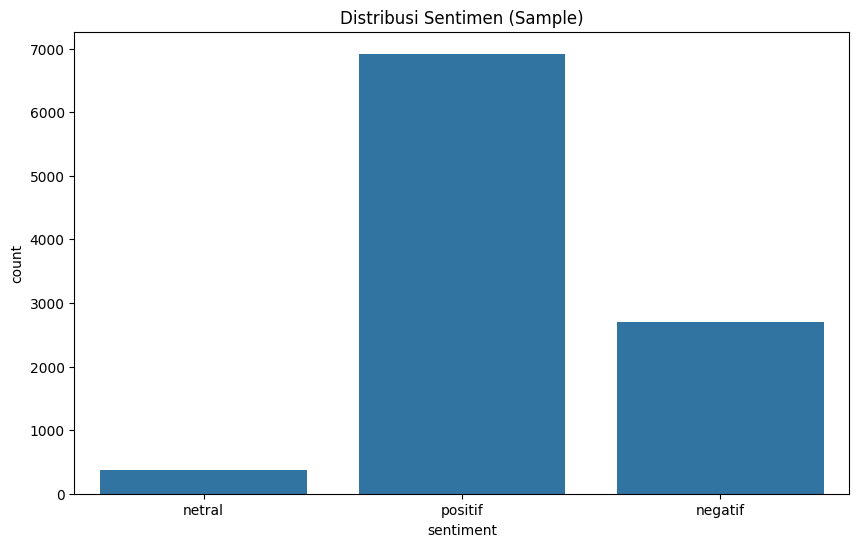

In [32]:
# Visualisasi distribusi sentimen - Tampilkan langsung di Colab
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df.sample(min(len(df), 10000), random_state=42))
plt.title('Distribusi Sentimen (Sample)')
plt.show()

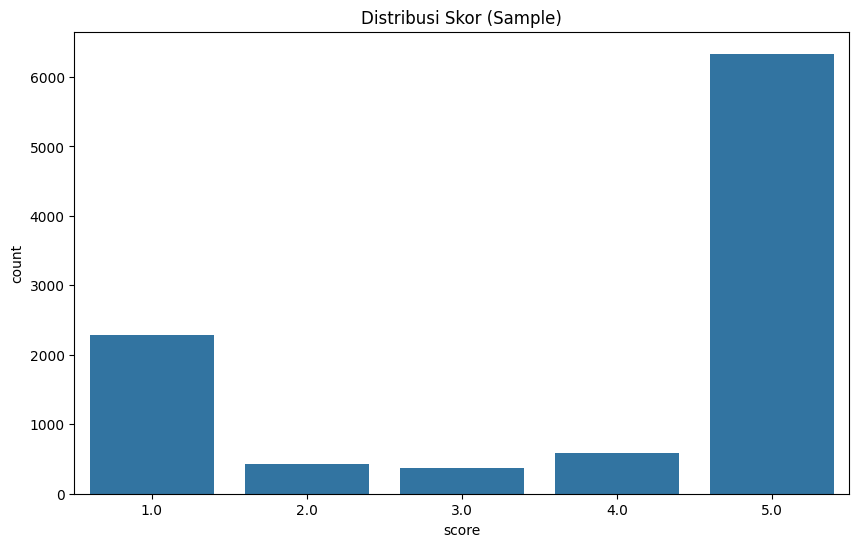


Praproses data selesai


In [33]:
# Visualisasi distribusi skor - Tampilkan langsung di Colab
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df.sample(min(len(df), 10000), random_state=42))
plt.title('Distribusi Skor (Sample)')
plt.show()  # Langsung tampilkan di Colab

print("\nPraproses data selesai")

In [34]:
# Cek distribusi panjang teks
text_lengths = df['processed_content'].str.len()
print(f"\nStatistik panjang teks:")
print(f"  Min: {text_lengths.min()}")
print(f"  Mean: {text_lengths.mean():.2f}")
print(f"  Median: {text_lengths.median()}")
print(f"  95 percentile: {text_lengths.quantile(0.95)}")
print(f"  Max: {text_lengths.max()}")

# Tentukan max_length berdasarkan persentil ke-95 atau nilai tetap
max_length = min(int(text_lengths.quantile(0.95)), 100)
print(f"Menggunakan max_length = {max_length} untuk padding")


Statistik panjang teks:
  Min: 0
  Mean: 54.11
  Median: 23.0
  95 percentile: 215.0
  Max: 645
Menggunakan max_length = 100 untuk padding


In [38]:
# Ambil fitur dan target
X = df['processed_content']
y = df['sentiment_code']


In [39]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nUkuran data training: {len(X_train)} sampel")
print(f"Ukuran data testing: {len(X_test)} sampel")


Ukuran data training: 206184 sampel
Ukuran data testing: 51547 sampel


In [40]:
# Tokenisasi - gunakan vocab size yang lebih besar untuk dataset besar
vocab_size = 15000  # Ditingkatkan dari 5000
print("\nMemulai tokenisasi...")

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)


Memulai tokenisasi...


In [41]:
# Simpan vocabulary size aktual
vocab_actual_size = len(tokenizer.word_index) + 1
print(f"Total kata unik dalam vocabulary: {vocab_actual_size}")

Total kata unik dalam vocabulary: 69791


In [42]:
# Tokenisasi dan padding untuk training set
print("Tokenisasi training set...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')


Tokenisasi training set...


In [43]:
# Tokenisasi dan padding untuk test set
print("Tokenisasi test set...")
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


Tokenisasi test set...


In [44]:
# MODEL 1: BiLSTM dengan optimasi
# ----------------------------------

def create_bilstm_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 1: BiLSTM dengan Embedding ---")
model1 = create_bilstm_model()
print(model1.summary())


--- MODEL 1: BiLSTM dengan Embedding ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
# Callbacks dengan lebih banyak opsi
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  patience=3,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=2,
                      min_lr=0.0001),
    ModelCheckpoint('best_model1.h5',
                    monitor='val_accuracy',
                    save_best_only=True)
]

In [46]:
# Training model 1 dengan batch size yang lebih besar
batch_size = 64  # Ditingkatkan untuk kecepatan
print(f"\nMemulai training Model 1 dengan batch size {batch_size}...")

history1 = model1.fit(
    X_train_pad, y_train,
    epochs=10,  # Dikurangi karena dataset lebih besar
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 1 dengan batch size 64...
Epoch 1/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8656 - loss: 0.3985

2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1111s 380ms/step - accuracy: 0.8656 - loss: 0.3985 - val_accuracy: 0.8954 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 2/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9058 - loss: 0.2944

2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1169s 383ms/step - accuracy: 0.9058 - loss: 0.2944 - val_accuracy: 0.8975 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 3/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9137 - loss: 0.2703

2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1160s 382ms/step - accuracy: 0.9137 - loss: 0.2703 - val_accuracy: 0.8982 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 4/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1175s 387ms/step - accuracy: 0.9198 - loss: 0.2509 - val_accuracy: 0.8956 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 5/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1132s 390ms/step - accuracy: 0.9252 - loss: 0.2300 - val_accuracy: 0.8928 - val_loss: 0.3636 - learning_rate: 5.0000e-04
Epoch 6/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 1140s 383ms/step - accuracy: 0.9315 - loss: 0.2110 - val_accuracy: 0.8885 - val_loss: 0.4016 - learning_rate: 5.0000e-04


In [49]:
# Evaluasi model 1
print("\nEvaluasi Model 1 pada test set...")
loss1, accuracy1 = model1.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 1 - Test Accuracy: {accuracy1*100:.2f}%")



Evaluasi Model 1 pada test set...
806/806 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.8999 - loss: 0.3089
Model 1 - Test Accuracy: 90.03%


In [58]:
# Prediksi dan evaluasi lanjutan
y_pred1 = model1.predict(X_test_pad, batch_size=batch_size)
y_pred_classes1 = np.argmax(y_pred1, axis=1)

print("Classification Report - Model 1:")
cr1 = classification_report(y_test, y_pred_classes1, target_names=['negatif', 'netral', 'positif'])
print(cr1)

806/806 ━━━━━━━━━━━━━━━━━━━━ 97s 117ms/step
Classification Report - Model 1:
              precision    recall  f1-score   support

     negatif       0.80      0.91      0.85     13954
      netral       0.00      0.00      0.00      2064
     positif       0.95      0.95      0.95     35529

    accuracy                           0.90     51547
   macro avg       0.58      0.62      0.60     51547
weighted avg       0.87      0.90      0.88     51547



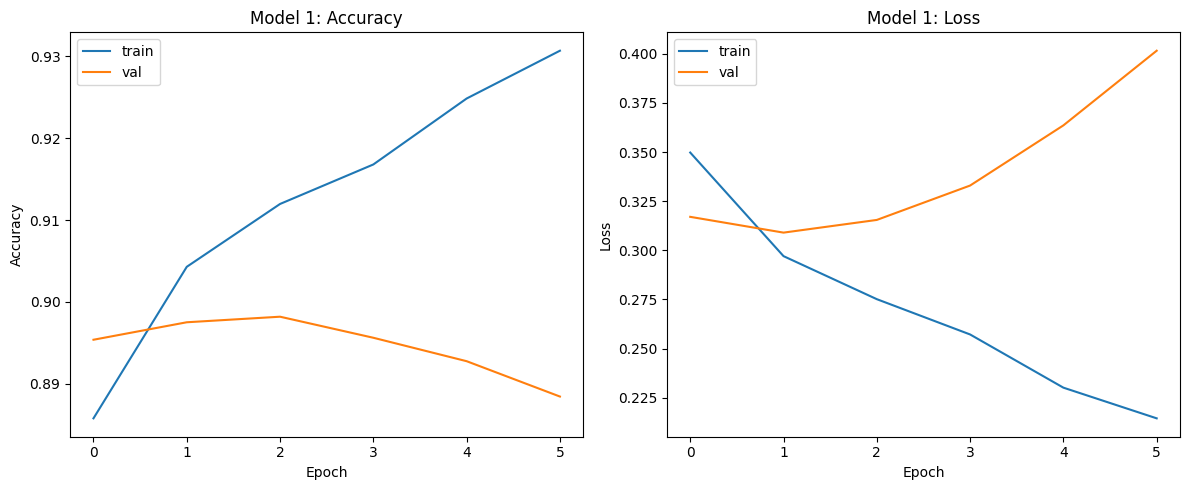

In [59]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()  # Tampilkan langsung di Colab


In [51]:
# ----------------------------------
# MODEL 2: CNN + Global Max Pooling
# ----------------------------------

def create_cnn_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Conv1D(128, 5, padding='same', activation='relu'),
        Conv1D(128, 3, padding='same', activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 2: CNN dengan Global Max Pooling ---")
model2 = create_cnn_model()
print(model2.summary())



--- MODEL 2: CNN dengan Global Max Pooling ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [52]:
# Training model 2
print(f"\nMemulai training Model 2 dengan batch size {batch_size}...")
history2 = model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 2 dengan batch size 64...
Epoch 1/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 430s 147ms/step - accuracy: 0.8701 - loss: 0.3891 - val_accuracy: 0.8966 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 425s 147ms/step - accuracy: 0.9091 - loss: 0.2840 - val_accuracy: 0.8959 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 3/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 440s 146ms/step - accuracy: 0.9196 - loss: 0.2502 - val_accuracy: 0.8943 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 4/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 430s 148ms/step - accuracy: 0.9302 - loss: 0.2097 - val_accuracy: 0.8898 - val_loss: 0.3751 - learning_rate: 5.0000e-04


In [53]:
# Evaluasi model 2
print("\nEvaluasi Model 2 pada test set...")
loss2, accuracy2 = model2.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 2 - Test Accuracy: {accuracy2*100:.2f}%")


Evaluasi Model 2 pada test set...
806/806 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9005 - loss: 0.3039
Model 2 - Test Accuracy: 90.04%


In [54]:
# Prediksi dan evaluasi lanjutan
y_pred2 = model2.predict(X_test_pad, batch_size=batch_size)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

print("Classification Report - Model 2:")
cr2 = classification_report(y_test, y_pred_classes2, target_names=['negatif', 'netral', 'positif'])
print(cr2)

806/806 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step
Classification Report - Model 2:
              precision    recall  f1-score   support

     negatif       0.80      0.91      0.85     13954
      netral       0.00      0.00      0.00      2064
     positif       0.95      0.95      0.95     35529

    accuracy                           0.90     51547
   macro avg       0.58      0.62      0.60     51547
weighted avg       0.87      0.90      0.88     51547



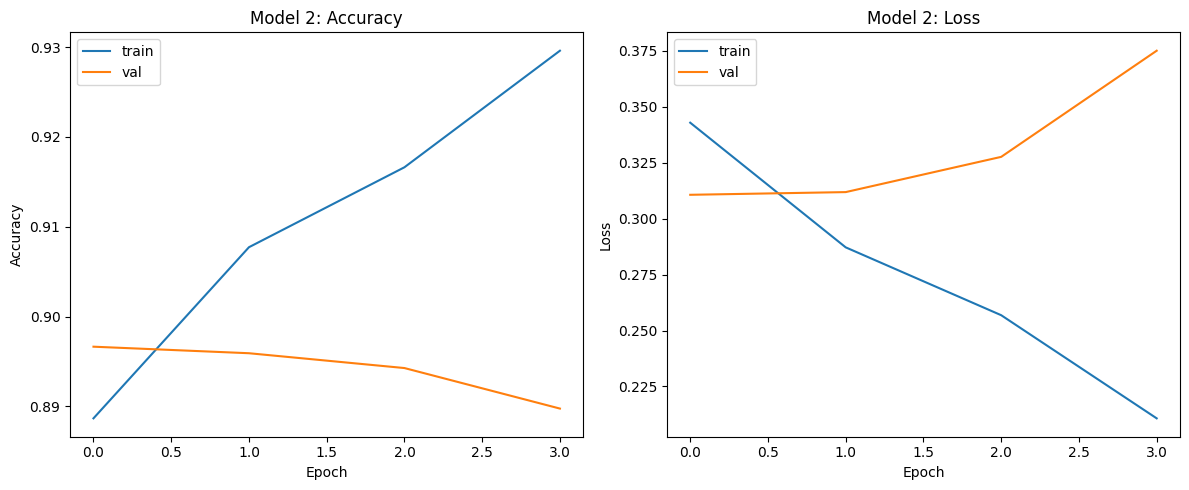

In [55]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [56]:
# ----------------------------------
# MODEL 3: Hybrid CNN-LSTM
# ----------------------------------

def create_cnn_lstm_model():
    model = Sequential([
        Embedding(input_dim=min(vocab_size, vocab_actual_size),
                  output_dim=128,
                  input_length=max_length),
        Conv1D(128, 3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

print("\n--- MODEL 3: Hybrid CNN-LSTM ---")
model3 = create_cnn_lstm_model()
print(model3.summary())


--- MODEL 3: Hybrid CNN-LSTM ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [57]:
# Training model 3
print(f"\nMemulai training Model 3 dengan batch size {batch_size}...")
history3 = model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Memulai training Model 3 dengan batch size 64...
Epoch 1/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 394s 134ms/step - accuracy: 0.8194 - loss: 0.5075 - val_accuracy: 0.8940 - val_loss: 0.3260 - learning_rate: 0.0010
Epoch 2/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 435s 131ms/step - accuracy: 0.9029 - loss: 0.3052 - val_accuracy: 0.8956 - val_loss: 0.3200 - learning_rate: 0.0010
Epoch 3/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 381s 131ms/step - accuracy: 0.9104 - loss: 0.2809 - val_accuracy: 0.8966 - val_loss: 0.3210 - learning_rate: 0.0010
Epoch 4/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 389s 134ms/step - accuracy: 0.9155 - loss: 0.2595 - val_accuracy: 0.8953 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 5/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 444s 134ms/step - accuracy: 0.9236 - loss: 0.2322 - val_accuracy: 0.8896 - val_loss: 0.3607 - learning_rate: 5.0000e-04
Epoch 6/10
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 379s 131ms/step - accuracy: 0.9281 - loss: 0.2145 - val_accuracy: 0.8907 - val_loss: 0.3831 - learning_rate: 5.000

In [60]:
# Evaluasi model 3
print("\nEvaluasi Model 3 pada test set...")
loss3, accuracy3 = model3.evaluate(X_test_pad, y_test, batch_size=batch_size)
print(f"Model 3 - Test Accuracy: {accuracy3*100:.2f}%")


Evaluasi Model 3 pada test set...
806/806 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.8987 - loss: 0.3145
Model 3 - Test Accuracy: 89.92%


In [61]:
# Prediksi dan evaluasi lanjutan
y_pred3 = model3.predict(X_test_pad, batch_size=batch_size)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

print("Classification Report - Model 3:")
cr3 = classification_report(y_test, y_pred_classes3, target_names=['negatif', 'netral', 'positif'])
print(cr3)

806/806 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step
Classification Report - Model 3:
              precision    recall  f1-score   support

     negatif       0.78      0.93      0.85     13954
      netral       0.00      0.00      0.00      2064
     positif       0.96      0.94      0.95     35529

    accuracy                           0.90     51547
   macro avg       0.58      0.62      0.60     51547
weighted avg       0.87      0.90      0.88     51547



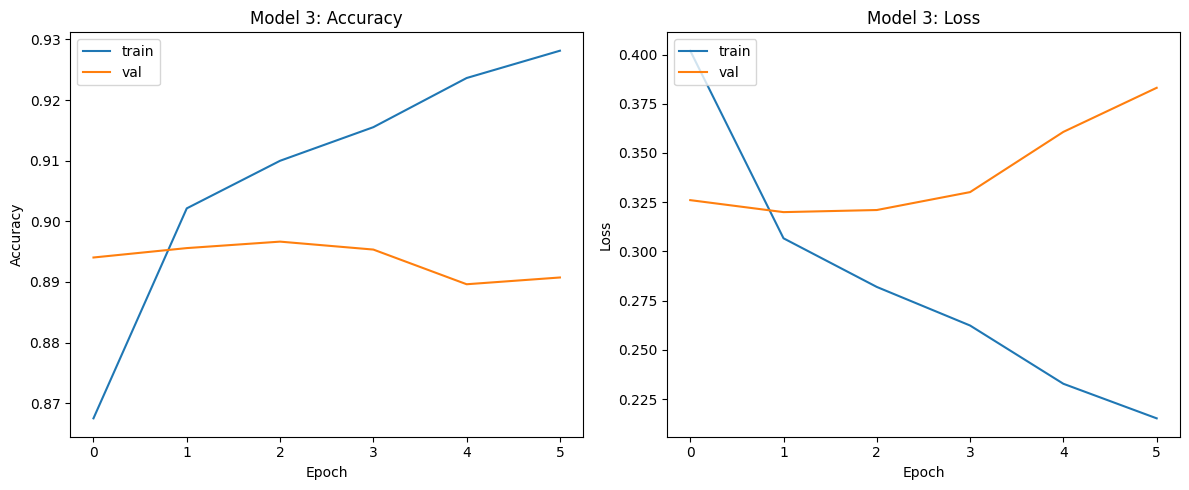

In [62]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [63]:
# ----------------------------------
# Perbandingan Ketiga Model
# ----------------------------------
print("\n--- Perbandingan Akurasi Ketiga Model ---")
comparison = pd.DataFrame({
    'Model': ['BiLSTM', 'CNN', 'CNN-LSTM'],
    'Akurasi Training': [
        history1.history['accuracy'][-1]*100,
        history2.history['accuracy'][-1]*100,
        history3.history['accuracy'][-1]*100
    ],
    'Akurasi Testing': [
        accuracy1*100,
        accuracy2*100,
        accuracy3*100
    ]
})
print(comparison)


--- Perbandingan Akurasi Ketiga Model ---
      Model  Akurasi Training  Akurasi Testing
0    BiLSTM         93.067658        90.028518
1       CNN         92.958802        90.036279
2  CNN-LSTM         92.814916        89.915997


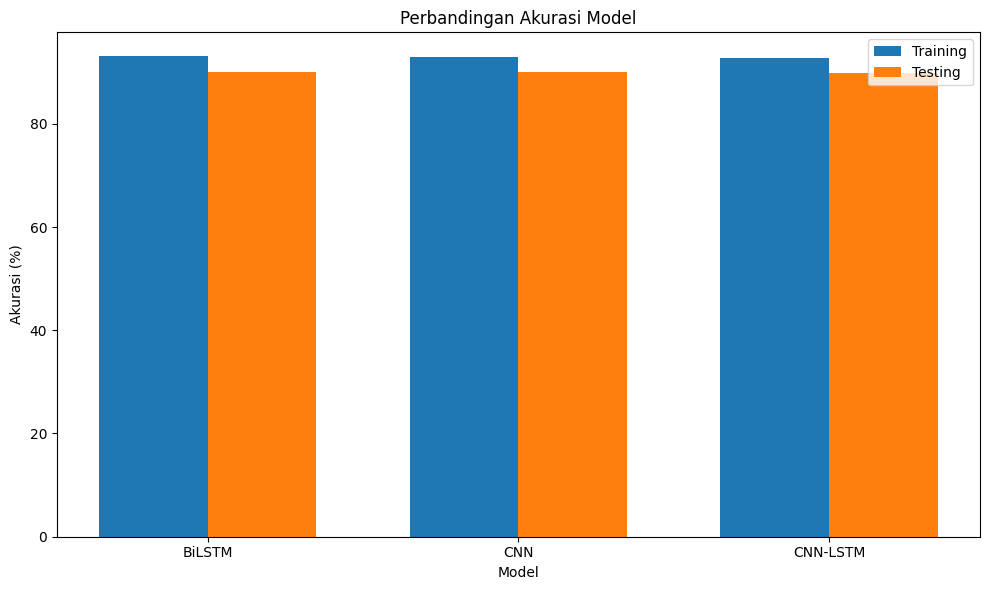

In [64]:
# Plot perbandingan
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(3)

plt.bar(index, comparison['Akurasi Training'], bar_width, label='Training')
plt.bar(index + bar_width, comparison['Akurasi Testing'], bar_width, label='Testing')

plt.xlabel('Model')
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Model')
plt.xticks(index + bar_width/2, comparison['Model'])
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
# ----------------------------------
# Fungsi Inferensi untuk Model Terbaik
# ----------------------------------
def predict_sentiment(text, model, tokenizer):
    # Praproses teks
    processed_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Prediksi
    prediction = model.predict(padded)[0]
    predicted_class = np.argmax(prediction)

    # Mengkonversi kembali ke label sentimen
    sentiments = {0: 'negatif', 1: 'netral', 2: 'positif'}
    sentiment = sentiments[predicted_class]

    confidence = prediction[predicted_class] * 100

    return {
        'text': text,
        'processed': processed_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negatif': prediction[0] * 100,
            'netral': prediction[1] * 100,
            'positif': prediction[2] * 100
        }
    }


In [66]:
# Cari model dengan akurasi terbaik
best_accuracy = max(accuracy1, accuracy2, accuracy3)
if best_accuracy == accuracy1:
    best_model = model1
    best_tokenizer = tokenizer
    model_name = "BiLSTM"
elif best_accuracy == accuracy2:
    best_model = model2
    best_tokenizer = tokenizer
    model_name = "CNN"
else:
    best_model = model3
    best_tokenizer = tokenizer
    model_name = "CNN-LSTM"

print(f"\nModel terbaik adalah {model_name} dengan akurasi {best_accuracy*100:.2f}%")


Model terbaik adalah CNN dengan akurasi 90.04%


In [67]:
# ----------------------------------
# Uji inferensi dengan beberapa contoh
# ----------------------------------
test_examples = [
    "Aplikasi bagus, sangat membantu aktivitas sehari-hari",
    "Aplikasi ini seringkali error dan membuat saya kecewa",
    "Biasa saja, tidak ada yang spesial",
    "Tolong diperbaiki lagi fiturnya, masih banyak bug",
    "Layanan pengirimannya cepat sekali, terimakasih gojek!"
]

print("\n--- Hasil Inferensi dengan Model Terbaik ---")
for text in test_examples:
    result = predict_sentiment(text, best_model, best_tokenizer)
    print(f"Teks: {result['text']}")
    print(f"Sentimen: {result['sentiment']} (confidence: {result['confidence']:.2f}%)")
    print(f"Probabilitas: Negatif={result['probabilities']['negatif']:.2f}%, Netral={result['probabilities']['netral']:.2f}%, Positif={result['probabilities']['positif']:.2f}%")
    print("-" * 50)


--- Hasil Inferensi dengan Model Terbaik ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Teks: Aplikasi bagus, sangat membantu aktivitas sehari-hari
Sentimen: positif (confidence: 99.61%)
Probabilitas: Negatif=0.15%, Netral=0.24%, Positif=99.61%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Teks: Aplikasi ini seringkali error dan membuat saya kecewa
Sentimen: negatif (confidence: 54.15%)
Probabilitas: Negatif=54.15%, Netral=9.28%, Positif=36.57%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Teks: Biasa saja, tidak ada yang spesial
Sentimen: negatif (confidence: 80.12%)
Probabilitas: Negatif=80.12%, Netral=8.54%, Positif=11.34%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Teks: Tolong diperbaiki lagi fiturnya, masih banyak bug
Sentimen: negatif (confidence: 45.79%)
Probabilitas: Negatif=45.79%, Netral=18.43%, Positif=35.78%
---------------------------------------

In [68]:
# Inferensi untuk beberapa sampel dari dataset asli
random_samples = df.sample(5)
print("\n--- Inferensi Sampel dari Dataset Asli ---")
for idx, row in random_samples.iterrows():
    original_text = row['content']
    original_sentiment = row['sentiment']
    result = predict_sentiment(original_text, best_model, best_tokenizer)

    print(f"ID Review: {row['reviewId'] if 'reviewId' in row else idx}")
    print(f"Teks Asli: {original_text}")
    print(f"Skor: {row['score']}")
    print(f"Sentimen Asli: {original_sentiment}")
    print(f"Sentimen Prediksi: {result['sentiment']} (confidence: {result['confidence']:.2f}%)")
    print("-" * 50)



--- Inferensi Sampel dari Dataset Asli ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ID Review: 77db4816-f839-4cda-99db-9089ee7af11d
Teks Asli: Orderan driver untuk gofood menurun dikarenakan tidak bisa menggunakan 2 voucher, sangat disayangkan
Skor: 1.0
Sentimen Asli: negatif
Sentimen Prediksi: negatif (confidence: 92.62%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ID Review: 9471750a-77a9-414c-be09-9ea0924fdeed
Teks Asli: Pemesanan gofood ga ngotak 1jam semua
Skor: 1.0
Sentimen Asli: negatif
Sentimen Prediksi: negatif (confidence: 95.86%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
ID Review: 2a5ce005-645b-4b64-8557-2302e5c1f359
Teks Asli: Mantapppp
Skor: 5.0
Sentimen Asli: positif
Sentimen Prediksi: positif (confidence: 99.85%)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ID Review: eef164d4-1889-467e-bc18-c09ed76b9c33
Teks Asli: Aplikasi yg sangat memb

In [69]:
# Simpan model terbaik dan tokenizer
print(f"\nMenyimpan model terbaik ({model_name})...")
best_model.save(f'best_sentiment_model_{model_name}.h5')


Menyimpan model terbaik (CNN)...


In [70]:
# Simpan tokenizer untuk penggunaan di masa depan
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Model terbaik telah disimpan sebagai 'best_sentiment_model_{model_name}.h5'")
print(f"Tokenizer telah disimpan sebagai 'tokenizer.pickle'")

Model terbaik telah disimpan sebagai 'best_sentiment_model_CNN.h5'
Tokenizer telah disimpan sebagai 'tokenizer.pickle'


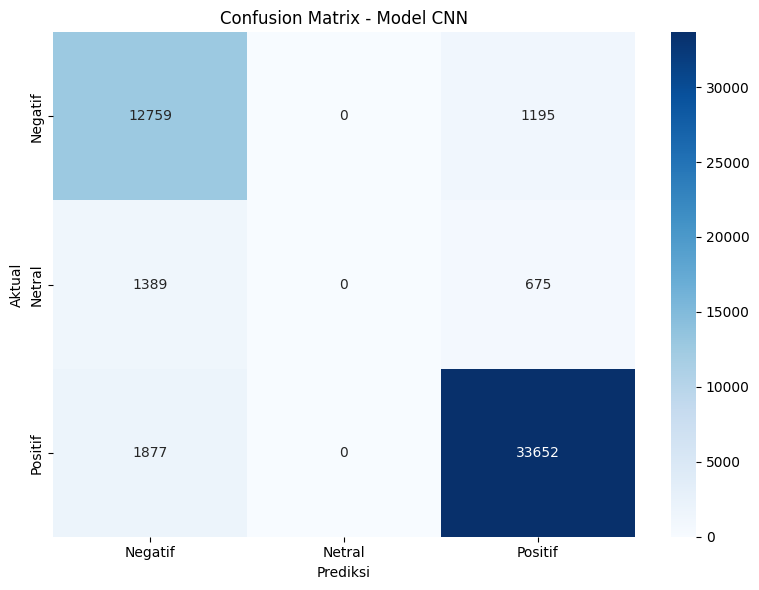

In [71]:
# Visualisasi confusion matrix untuk model terbaik
if best_accuracy == accuracy1:
    y_pred_classes = y_pred_classes1
elif best_accuracy == accuracy2:
    y_pred_classes = y_pred_classes2
else:
    y_pred_classes = y_pred_classes3

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title(f'Confusion Matrix - Model {model_name}')
plt.tight_layout()
plt.show()

In [72]:
print("\nAnalisis Sentimen selesai!")


Analisis Sentimen selesai!
